In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, SimpleRNN, Reshape, GRU, Dropout, BatchNormalization, Attention, Dot
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, mean_squared_error
from imblearn.over_sampling import SMOTE

In [2]:
folder_path = 'C:\\Users\\Administrator\\Documents\\TA\\dataset_feature_extracted\\'

In [3]:
train_folder = 'C:\\Users\\Administrator\\Documents\\TA\\dataset_feature_extracted\\training_set'
test_folder = 'C:\\Users\\Administrator\\Documents\\TA\\dataset_feature_extracted\\test_set'

Delete NaN Row

In [4]:
# def delete_nan_row(file_path):
#     df = pd.read_csv(file_path)

#     df = df.dropna()

#     df.to_csv(file_path, index=False)

# file_list = os.listdir(folder_path)

# for file_name in file_list:
#     if file_name.endswith('.csv'):
#         file_path = os.path.join(folder_path, file_name)
#         delete_nan_row(file_path)

# print("Proses selesai.")

Test Train Split

In [4]:
record_names = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']

for record_name in record_names:
    df = pd.read_csv(f'C:\\Users\\Administrator\\Documents\\TA\\dataset_feature_extracted\\record_{record_name}.csv')
    df.head()

    unique_labels = df.iloc[:, -1].unique()
    print(record_name, unique_labels)

100 ['N' 'A' 'V']
101 ['N' 'A']
102 ['V' 'N']
103 ['N' 'A']
104 ['N' 'V']
105 ['N' 'V']
106 ['N' 'V']
107 ['V']
108 ['N' 'V' 'A' 'F']
109 ['L' 'F' 'V']
111 ['L' 'V']
112 ['N' 'A']
113 ['N' 'a']
114 ['N' 'V' 'J' 'F' 'A']
115 ['N']
116 ['N' 'V' 'A']
117 ['N' 'A']
118 ['R' 'V' 'A']
119 ['V' 'N']
121 ['N' 'A' 'V']
122 ['N']
123 ['N']
124 ['R' 'J' 'V' 'F' 'A']
200 ['V' 'N' 'A' 'F']
201 ['N' 'a' 'V' 'A' 'J' 'F']
202 ['N' 'V' 'A' 'a' 'F']
203 ['N' 'V' 'a']
205 ['N' 'V' 'F' 'A']
207 ['V' 'R' 'L' 'E' 'A']
208 ['V' 'F' 'N']
209 ['N' 'A' 'V']
210 ['N' 'F' 'V' 'a' 'E']
212 ['R' 'N']
213 ['N' 'F' 'A' 'V' 'a']
214 ['L' 'V' 'F']
215 ['N' 'V' 'A']
217 ['V' 'N']
219 ['N' 'V' 'F' 'A']
220 ['N' 'A']
221 ['N' 'V']
222 ['N' 'A' 'J']
223 ['N' 'V' 'A' 'F' 'a']
228 ['N' 'V' 'A']
230 ['N' 'V']
231 ['R' 'N' 'A']
232 ['R' 'A']
233 ['V' 'N' 'A' 'F']
234 ['N' 'J']


Split Train and Test Phase

In [5]:
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

dfs = []

for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    df = pd.read_csv(file_path, header=None)

    dfs.append(df)

combined_data = pd.concat(dfs, ignore_index=True)

# labels_to_eliminate = ['a', 'E', 'F', 'J']

# filtered_data = combined_data[~combined_data.iloc[:, -1].isin(labels_to_eliminate)]

X = combined_data.iloc[:, :-1] 
y = combined_data.iloc[:, -1]

In [7]:
# SMOTE
# 

In [6]:
y.unique()

array(['A', 'N', 'V', 'F', 'L', 'a', 'J', 'R', 'E'], dtype=object)

In [7]:
le = LabelEncoder()
y = le.fit_transform(y)
y

array([0, 5, 5, ..., 5, 5, 5])

In [8]:
# Menghitung banyaknya masing-masing label
label_counts = np.bincount(y)

# Menampilkan hasil
for label, count in enumerate(label_counts):
    print(f'Label {label}: {count} occurrences')

Label 0: 2440 occurrences
Label 1: 106 occurrences
Label 2: 766 occurrences
Label 3: 81 occurrences
Label 4: 8022 occurrences
Label 5: 9445 occurrences
Label 6: 6265 occurrences
Label 7: 4834 occurrences
Label 8: 59 occurrences


In [9]:
sm = SMOTE(random_state=42)
X_resampling, y_resampling = sm.fit_resample(X, y)

In [10]:
# Menghitung banyaknya masing-masing label
label_counts = np.bincount(y_resampling)

# Menampilkan hasil
for label, count in enumerate(label_counts):
    print(f'Label {label}: {count} occurrences')

Label 0: 9445 occurrences
Label 1: 9445 occurrences
Label 2: 9445 occurrences
Label 3: 9445 occurrences
Label 4: 9445 occurrences
Label 5: 9445 occurrences
Label 6: 9445 occurrences
Label 7: 9445 occurrences
Label 8: 9445 occurrences


In [11]:
for i in range(9):
    print(i, "=", le.inverse_transform([i]))

0 = ['A']
1 = ['E']
2 = ['F']
3 = ['J']
4 = ['L']
5 = ['N']
6 = ['R']
7 = ['V']
8 = ['a']


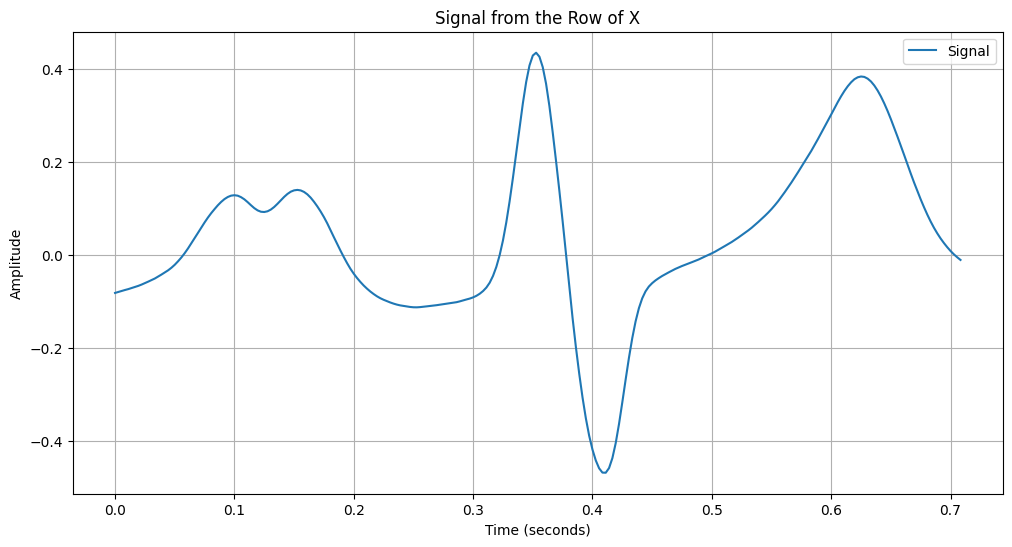

array([8])

In [12]:
signal_row = X_resampling.iloc[80000, :].values
fs = 360

# Create a time axis based on the sampling frequency
time_axis = np.arange(0, len(signal_row)) / fs

# Plot the signal
plt.figure(figsize=(12, 6))
plt.plot(time_axis, signal_row, label='Signal')
plt.title('Signal from the Row of X')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

pd.DataFrame(y_resampling).iloc[80000, :].values

In [13]:
X_resampling

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,-0.062349,-0.059537,-0.055399,-0.050137,-0.044365,-0.037571,-0.030063,-0.021636,-0.013412,-0.005289,0.002425,0.009529,0.015612,0.020574,0.024210,0.027234,0.029238,0.030223,0.030595,0.030561,0.030220,0.029983,0.029848,0.029714,0.029478,0.029039,0.028396,0.027856,0.027418,0.026777,0.026035,0.025497,0.025062,0.025239,0.025826,0.026515,0.027204,0.027894,0.028075,0.028154,...,-0.057658,-0.058452,-0.060063,-0.061776,-0.063897,-0.066019,-0.068446,-0.070568,-0.072383,-0.072872,-0.072443,-0.071299,-0.069850,-0.067891,-0.065829,-0.063054,-0.060176,-0.057503,-0.055136,-0.053075,-0.050709,-0.047322,-0.043527,-0.039732,-0.035631,-0.031122,-0.026001,-0.020677,-0.015760,-0.011048,-0.006234,-0.001522,0.002985,0.007697,0.012204,0.016507,0.020197,0.022663,0.024108,0.024635
1,0.005020,0.005367,0.006225,0.007388,0.008346,0.009100,0.009752,0.010505,0.010952,0.010990,0.010722,0.009943,0.009164,0.008589,0.008217,0.007743,0.006962,0.005569,0.004278,0.002884,0.001387,-0.000620,-0.002627,-0.004430,-0.005724,-0.006201,-0.005863,-0.005525,-0.005085,-0.004748,-0.004411,-0.003666,-0.003228,-0.003198,-0.003169,-0.003140,-0.002805,-0.002266,-0.001830,-0.001190,...,-0.083767,-0.083780,-0.083896,-0.084114,-0.084434,-0.084958,-0.085584,-0.086108,-0.086633,-0.086953,-0.087376,-0.087799,-0.087712,-0.086400,-0.083966,-0.080410,-0.076038,-0.070237,-0.063212,-0.054860,-0.046100,-0.037137,-0.028479,-0.020230,-0.012695,-0.005467,0.000843,0.006337,0.010810,0.014773,0.018429,0.022188,0.025436,0.028786,0.031932,0.034975,0.037611,0.040144,0.041963,0.043578
2,-0.014524,-0.013170,-0.012224,-0.012094,-0.012678,-0.014384,-0.016906,-0.019734,-0.022051,-0.024061,-0.025561,-0.027264,-0.028661,-0.029751,-0.030637,-0.031216,-0.031897,-0.032884,-0.033462,-0.033835,-0.034004,-0.033867,-0.034137,-0.033999,-0.033656,-0.033313,-0.032561,-0.031298,-0.029934,-0.028058,-0.026386,-0.024612,-0.022429,-0.019940,-0.017858,-0.015878,-0.014000,-0.012223,-0.010038,-0.007648,...,-0.073061,-0.073882,-0.073784,-0.073891,-0.074303,-0.074614,-0.075740,-0.077173,-0.077993,-0.078405,-0.078612,-0.078514,-0.078415,-0.077296,-0.075054,-0.072506,-0.069957,-0.066593,-0.062412,-0.057312,-0.051396,-0.044970,-0.038237,-0.030893,-0.023650,-0.016917,-0.010184,-0.003553,0.002772,0.008995,0.014605,0.019910,0.025521,0.030724,0.034804,0.037864,0.039700,0.040413,0.040106,0.038778
3,0.000127,-0.001334,-0.002896,-0.004865,-0.006834,-0.009414,-0.011586,-0.013349,-0.014805,-0.016056,-0.017103,-0.017945,-0.018072,-0.017586,-0.016997,-0.016408,-0.015716,-0.015227,-0.014738,-0.014145,-0.013757,-0.013367,-0.013181,-0.013199,-0.013113,-0.012721,-0.012532,-0.012546,-0.012662,-0.012777,-0.013402,-0.013821,-0.014546,-0.015169,-0.015892,-0.016819,-0.017847,-0.018160,-0.018370,-0.018171,...,-0.090142,-0.089169,-0.088807,-0.088648,-0.088591,-0.088431,-0.088576,-0.088414,-0.087741,-0.085945,-0.083229,-0.079799,-0.075449,-0.069364,-0.062054,-0.054437,-0.046921,-0.039812,-0.032805,-0.026103,-0.020421,-0.016064,-0.012319,-0.008676,-0.005133,-0.001590,0.002158,0.005703,0.009554,0.013202,0.015729,0.017746,0.019151,0.019639,0.019821,0.018984,0.017535,0.016393,0.015558,0.014723
4,0.013770,0.014504,0.015136,0.015563,0.015480,0.014989,0.014294,0.012883,0.011065,0.008532,0.005795,0.003363,0.001340,-0.000582,-0.002606,-0.004834,-0.006348,-0.007149,-0.007949,-0.008954,-0.009857,-0.010250,-0.009827,-0.009200,-0.008471,-0.007538,-0.006504,-0.005572,-0.004640,-0.003708,-0.003083,-0.003070,-0.003466,-0.003963,-0.004462,-0.004348,-0.004132,-0.003508,-0.002783,-0.002262,...,-0.103702,-0.108418,-0.113337,-0.118053,-0.122259,-0.125342,-0.127303,-0.128448,-0.128470,-0.127370,-0.125045,-0.121802,-0.118050,-0.114297,-0.110034,-0.105363,-0.099876,-0.093776,-0.087064,-0.079945,-0.07221

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_resampling, y_resampling, test_size=0.2, random_state=42)

Classification Phase

In [15]:
num_classes = 9
input_shape = (256, 1)
epochs = 20
batch_size = 32

In [18]:
# K FOLD -> ambil yang baik -> test di data testing

In [16]:
def plot_training_history(history):
    # Plot training history
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

#1 CLSTM

In [20]:
def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional layers for feature extraction
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Add a Dense layer before LSTM for additional complexity
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())

    # Reshape the output to 2D
    model.add(Reshape((-1, model.output_shape[-1])))

    # LSTM layers for sequence modeling
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(128))
    model.add(Dropout(0.5))

    # Flatten the output after the last LSTM layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with adjusted learning rate
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [21]:
# class CustomKerasClassifier(KerasClassifier):
#     def __init__(self, filters1=32, kernel_size1=5, filters2=64, kernel_size2=5, lstm_units=50, dense_units=128, **kwargs):
#         self.filters1 = filters1
#         self.kernel_size1 = kernel_size1
#         self.filters2 = filters2
#         self.kernel_size2 = kernel_size2
#         self.lstm_units = lstm_units
#         self.dense_units = dense_units
#         super().__init__(**kwargs)

# def create_cnn_lstm_model_tuning(input_shape, filters1=32, kernel_size1=5, filters2=64, kernel_size2=5, lstm_units=50, dense_units=128, num_classes=num_classes):
#     model = Sequential()
#     model.add(Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu', input_shape=input_shape))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Conv1D(filters=filters2, kernel_size=kernel_size2, activation='relu'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Reshape((-1, model.output_shape[-1])))
#     model.add(LSTM(lstm_units, return_sequences=True))
#     model.add(LSTM(lstm_units))
#     model.add(Dense(dense_units, activation='relu'))
#     model.add(Dense(num_classes, activation='softmax'))
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model

# keras_model_cnn_lstm_tuning = CustomKerasClassifier(build_fn=create_cnn_lstm_model_tuning, input_shape=input_shape, epochs=epochs, batch_size=batch_size, verbose=0)

# param_grid = {
#     'input_shape': [input_shape],  
#     'filters1': [32, 64, 128],
#     'kernel_size1': [3, 5, 7],
#     'filters2': [64, 128, 256],
#     'kernel_size2': [3, 5, 7],
#     'lstm_units': [50, 100, 150],
#     'dense_units': [64, 128, 256]
# }


In [22]:
cnn_lstm = create_cnn_lstm_model(input_shape, num_classes)
cnn_lstm.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 254, 128)          512       
                                                                 
 max_pooling1d (MaxPooling1  (None, 127, 128)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 256)          98560     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 62, 256)           0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 15872)             0         
                                                                 
 dense (Dense)               (None, 512)             

In [23]:
history = cnn_lstm.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

plot_training_history(history)

Epoch 1/20




SystemError: D:\_w\1\s\Objects\listobject.c:324: bad argument to internal function

In [ ]:
y_pred = cnn_lstm.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

# Menghitung dan mencetak akurasi
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Menghitung dan mencetak confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Menghitung dan mencetak classification report
class_report = classification_report(y_test, y_pred_classes)
print('Classification Report:')
print(class_report)


194/194 [==============================] - 5s 18ms/step
Accuracy: 0.9871
Confusion Matrix:
[[ 455    0   24    2    1]
 [   0 1560    0    0    2]
 [  11    4 1861    1   12]
 [   5    0    6 1252    2]
 [   1    3    6    0  994]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       482
           1       1.00      1.00      1.00      1562
           2       0.98      0.99      0.98      1889
           3       1.00      0.99      0.99      1265
           4       0.98      0.99      0.99      1004

    accuracy                           0.99      6202
   macro avg       0.98      0.98      0.98      6202
weighted avg       0.99      0.99      0.99      6202



In [ ]:
# Menghitung dan mencetak precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

# Menghitung dan mencetak sensitivity (recall)
sensitivity = recall_score(y_test, y_pred_classes, average='weighted')
print(f'Sensitivity (Recall): {sensitivity:.4f}')

# Menghitung dan mencetak F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9871
Sensitivity (Recall): 0.9871
F1 Score: 0.9871


In [ ]:
input_sample = X_test.iloc[9, :].values

# Menambahkan dimensi batch dan timestep
input_sample = input_sample.reshape((1, input_sample.shape[0], 1))

pred = cnn_lstm.predict(input_sample)
print(np.argmax(pred))
# print(pred)

predicted_class = le.inverse_transform([np.argmax(pred)])

print(predicted_class[0])


1/1 [==============================] - 0s 38ms/step
3
R


In [ ]:
input_sample

array([[[ 0.05690749],
        [ 0.0639932 ],
        [ 0.06954845],
        [ 0.07245077],
        [ 0.07280222],
        [ 0.07131705],
        [ 0.06901568],
        [ 0.06620421],
        [ 0.06390305],
        [ 0.06333667],
        [ 0.06511732],
        [ 0.0680205 ],
        [ 0.07143395],
        [ 0.07474541],
        [ 0.07815897],
        [ 0.08045013],
        [ 0.08100663],
        [ 0.07972642],
        [ 0.07824214],
        [ 0.07675788],
        [ 0.07639607],
        [ 0.07654446],
        [ 0.07801936],
        [ 0.08082077],
        [ 0.08505072],
        [ 0.0896888 ],
        [ 0.09504112],
        [ 0.09906684],
        [ 0.10176598],
        [ 0.10303647],
        [ 0.10359259],
        [ 0.10384251],
        [ 0.10409232],
        [ 0.10434204],
        [ 0.10602021],
        [ 0.10963703],
        [ 0.1146823 ],
        [ 0.12044171],
        [ 0.12620098],
        [ 0.13226621],
        [ 0.13853537],
        [ 0.14511048],
        [ 0.15219561],
        [ 0

In [ ]:
pd.DataFrame(y_test).iloc[9, :].values

array([3])

#2 CGRU

In [ ]:
def create_cnn_gru_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional layers for feature extraction
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Add a Dense layer before GRU for additional complexity
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())

    # Reshape the output to 2D
    model.add(Reshape((-1, model.output_shape[-1])))

    # GRU layers for sequence modeling
    model.add(GRU(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(GRU(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(GRU(128))
    model.add(Dropout(0.5))

    # Flatten the output after the last GRU layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with adjusted learning rate
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
cnn_gru = create_cnn_gru_model(input_shape, num_classes)
cnn_gru.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, 254, 128)          512       
                                                                 
 max_pooling1d_36 (MaxPooli  (None, 127, 128)          0         
 ng1D)                                                           
                                                                 
 conv1d_37 (Conv1D)          (None, 125, 256)          98560     
                                                                 
 max_pooling1d_37 (MaxPooli  (None, 62, 256)           0         
 ng1D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 15872)             0         
                                                                 
 dense_42 (Dense)            (None, 512)             

Epoch 1/20
776/776 [==============================] - 88s 105ms/step - loss: 0.3458 - accuracy: 0.8939 - val_loss: 0.0939 - val_accuracy: 0.9719
Epoch 2/20
776/776 [==============================] - 84s 108ms/step - loss: 0.1602 - accuracy: 0.9546 - val_loss: 0.0927 - val_accuracy: 0.9745
Epoch 3/20
776/776 [==============================] - 86s 110ms/step - loss: 0.1313 - accuracy: 0.9639 - val_loss: 0.0850 - val_accuracy: 0.9763
Epoch 4/20
776/776 [==============================] - 82s 106ms/step - loss: 0.1112 - accuracy: 0.9692 - val_loss: 0.0766 - val_accuracy: 0.9792
Epoch 5/20
776/776 [==============================] - 89s 115ms/step - loss: 0.1001 - accuracy: 0.9723 - val_loss: 0.0665 - val_accuracy: 0.9816
Epoch 6/20
776/776 [==============================] - 85s 110ms/step - loss: 0.0810 - accuracy: 0.9772 - val_loss: 0.0668 - val_accuracy: 0.9805
Epoch 7/20
776/776 [==============================] - 88s 113ms/step - loss: 0.0828 - accuracy: 0.9781 - val_loss: 0.0551 - val_ac

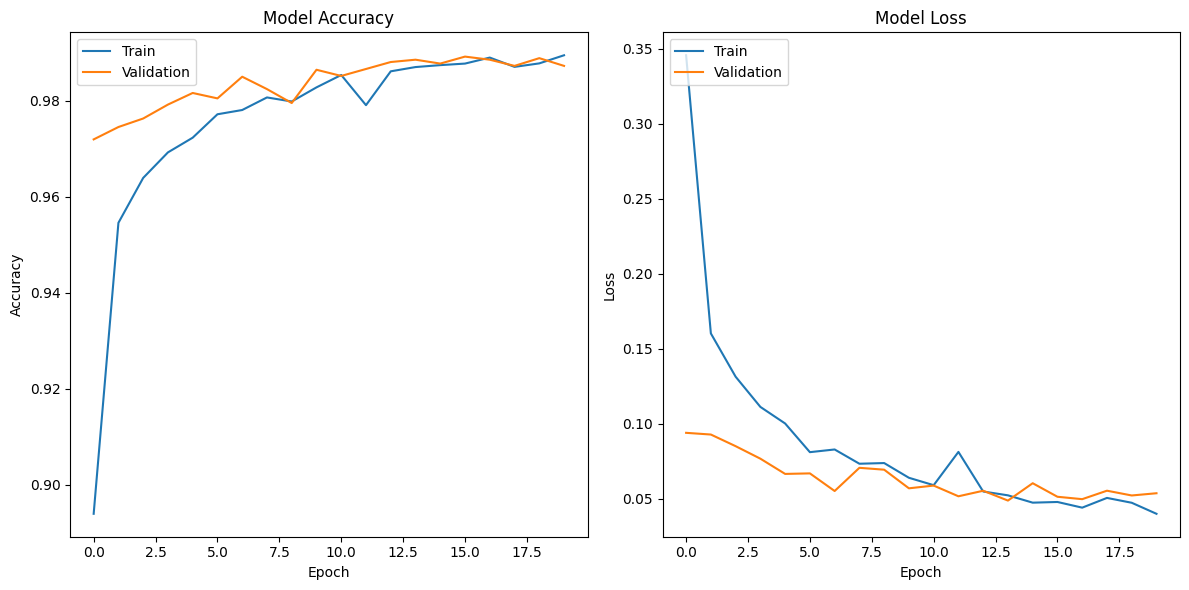

In [ ]:
history = cnn_gru.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

plot_training_history(history)

In [ ]:
y_pred = cnn_gru.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

# Menghitung dan mencetak akurasi
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Menghitung dan mencetak confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Menghitung dan mencetak classification report
class_report = classification_report(y_test, y_pred_classes)
print('Classification Report:')
print(class_report)

194/194 [==============================] - 4s 16ms/step
Accuracy: 0.9873
Confusion Matrix:
[[ 450    0   27    5    0]
 [   2 1553    1    1    5]
 [  12    1 1872    1    3]
 [   2    0    1 1262    0]
 [   2    4    9    3  986]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       482
           1       1.00      0.99      1.00      1562
           2       0.98      0.99      0.99      1889
           3       0.99      1.00      0.99      1265
           4       0.99      0.98      0.99      1004

    accuracy                           0.99      6202
   macro avg       0.98      0.98      0.98      6202
weighted avg       0.99      0.99      0.99      6202



In [ ]:
# Menghitung dan mencetak precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

# Menghitung dan mencetak sensitivity (recall)
sensitivity = recall_score(y_test, y_pred_classes, average='weighted')
print(f'Sensitivity (Recall): {sensitivity:.4f}')

# Menghitung dan mencetak F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9872
Sensitivity (Recall): 0.9873
F1 Score: 0.9872


#3 CRNN

In [ ]:
def create_cnn_rnn_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional layers for feature extraction
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Add a Dense layer before SimpleRNN for additional complexity
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())

    # Reshape the output to 2D
    model.add(Reshape((-1, model.output_shape[-1])))

    # SimpleRNN layers for sequence modeling
    model.add(SimpleRNN(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(SimpleRNN(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(SimpleRNN(128))
    model.add(Dropout(0.5))

    # Flatten the output after the last SimpleRNN layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with adjusted learning rate
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
cnn_rnn = create_cnn_rnn_model(input_shape, num_classes)
cnn_rnn.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_40 (Conv1D)          (None, 254, 128)          512       
                                                                 
 max_pooling1d_40 (MaxPooli  (None, 127, 128)          0         
 ng1D)                                                           
                                                                 
 conv1d_41 (Conv1D)          (None, 125, 256)          98560     
                                                                 
 max_pooling1d_41 (MaxPooli  (None, 62, 256)           0         
 ng1D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 15872)             0         
                                                                 
 dense_48 (Dense)            (None, 512)             

Epoch 1/20
776/776 [==============================] - 89s 108ms/step - loss: 0.4327 - accuracy: 0.8658 - val_loss: 0.1553 - val_accuracy: 0.9544
Epoch 2/20
776/776 [==============================] - 85s 110ms/step - loss: 0.2122 - accuracy: 0.9396 - val_loss: 0.1319 - val_accuracy: 0.9657
Epoch 3/20
776/776 [==============================] - 77s 100ms/step - loss: 0.1681 - accuracy: 0.9506 - val_loss: 0.1112 - val_accuracy: 0.9737
Epoch 4/20
776/776 [==============================] - 83s 107ms/step - loss: 0.1385 - accuracy: 0.9617 - val_loss: 0.0790 - val_accuracy: 0.9776
Epoch 5/20
776/776 [==============================] - 79s 101ms/step - loss: 0.1132 - accuracy: 0.9678 - val_loss: 0.0830 - val_accuracy: 0.9777
Epoch 6/20
776/776 [==============================] - 90s 116ms/step - loss: 0.1004 - accuracy: 0.9715 - val_loss: 0.0778 - val_accuracy: 0.9805
Epoch 7/20
776/776 [==============================] - 78s 101ms/step - loss: 0.1057 - accuracy: 0.9721 - val_loss: 0.0866 - val_ac

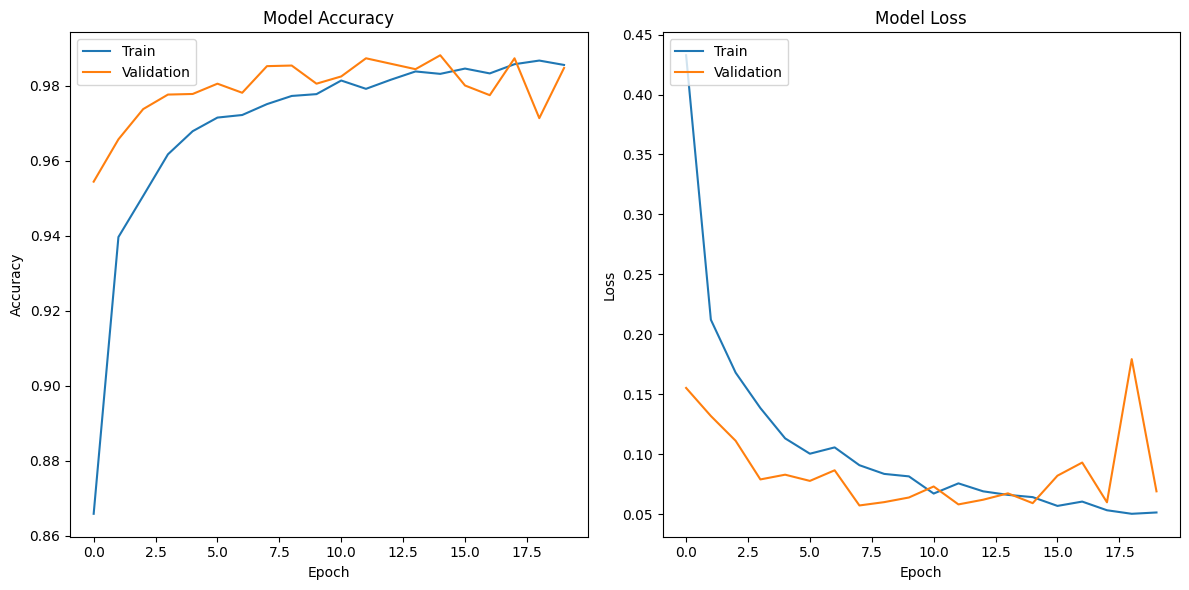

In [ ]:
history = cnn_rnn.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

plot_training_history(history)

In [ ]:
y_pred = cnn_rnn.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

# Menghitung dan mencetak akurasi
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Menghitung dan mencetak confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Menghitung dan mencetak classification report
class_report = classification_report(y_test, y_pred_classes)
print('Classification Report:')
print(class_report)

194/194 [==============================] - 3s 14ms/step
Accuracy: 0.9847
Confusion Matrix:
[[ 432    0   47    3    0]
 [   1 1550    3    0    8]
 [   4    2 1877    0    6]
 [   3    0    4 1258    0]
 [   3    4    7    0  990]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.93       482
           1       1.00      0.99      0.99      1562
           2       0.97      0.99      0.98      1889
           3       1.00      0.99      1.00      1265
           4       0.99      0.99      0.99      1004

    accuracy                           0.98      6202
   macro avg       0.98      0.97      0.98      6202
weighted avg       0.98      0.98      0.98      6202



In [ ]:
# Menghitung dan mencetak precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

# Menghitung dan mencetak sensitivity (recall)
sensitivity = recall_score(y_test, y_pred_classes, average='weighted')
print(f'Sensitivity (Recall): {sensitivity:.4f}')

# Menghitung dan mencetak F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9848
Sensitivity (Recall): 0.9847
F1 Score: 0.9845


#4 CAttention

In [18]:
def create_cnn_attention_gru_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional layers for feature extraction
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Add a Dense layer before GRU for additional complexity
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())

    # Reshape the output to 2D
    model.add(Reshape((-1, model.output_shape[-1])))

    # Split the output into query and value
    query_value = Dense(64, activation='relu')(model.output)

    # Attention layer (manual implementation)
    query = Dense(64, activation='relu')(query_value)
    value = Dense(64, activation='relu')(query_value)
    attention_scores = Attention()([query, value])

    # Weighted sum of value using attention scores
    attended_value = Dot(axes=(1, 1))([attention_scores, value])

    # GRU layers for sequence modeling
    gru_output = GRU(128, return_sequences=True)(attended_value)
    gru_output = Dropout(0.5)(gru_output)
    gru_output = GRU(128, return_sequences=True)(gru_output)
    gru_output = Dropout(0.5)(gru_output)
    gru_output = GRU(128)(gru_output)
    gru_output = Dropout(0.5)(gru_output)

    # Fully connected layer
    dense_output = Dense(512, activation='relu')(gru_output)
    dense_output = BatchNormalization()(dense_output)

    # Output layer
    output = Dense(num_classes, activation='softmax')(dense_output)

    # Create the model
    model = Model(inputs=model.input, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [19]:
cnn_attention = create_cnn_attention_gru_model(input_shape, num_classes)
cnn_attention.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 conv1d_input (InputLayer)   [(None, 256, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 254, 128)             512       ['conv1d_input[0][0]']        
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 127, 128)             0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 125, 256)             98560     ['max_pooling1d[0][0]']

Epoch 1/20


776/776 [==============================] - 170s 209ms/step - loss: 0.2979 - accuracy: 0.9099 - val_loss: 0.4723 - val_accuracy: 0.8586
Epoch 2/20
776/776 [==============================] - 166s 214ms/step - loss: 0.1505 - accuracy: 0.9577 - val_loss: 0.1591 - val_accuracy: 0.9565
Epoch 3/20
776/776 [==============================] - 168s 217ms/step - loss: 0.1150 - accuracy: 0.9706 - val_loss: 0.0769 - val_accuracy: 0.9819
Epoch 4/20
776/776 [==============================] - 169s 218ms/step - loss: 0.1089 - accuracy: 0.9723 - val_loss: 0.1343 - val_accuracy: 0.9649
Epoch 5/20
776/776 [==============================] - 169s 218ms/step - loss: 0.0998 - accuracy: 0.9738 - val_loss: 0.1150 - val_accuracy: 0.9715
Epoch 6/20
776/776 [==============================] - 172s 222ms/step - loss: 0.0789 - accuracy: 0.9797 - val_loss: 0.0659 - val_accuracy: 0.9829
Epoch 7/20
776/776 [==============================] - 167s 215ms/step - loss: 0.0773 - accuracy: 0.9800 - val_loss: 0.0961

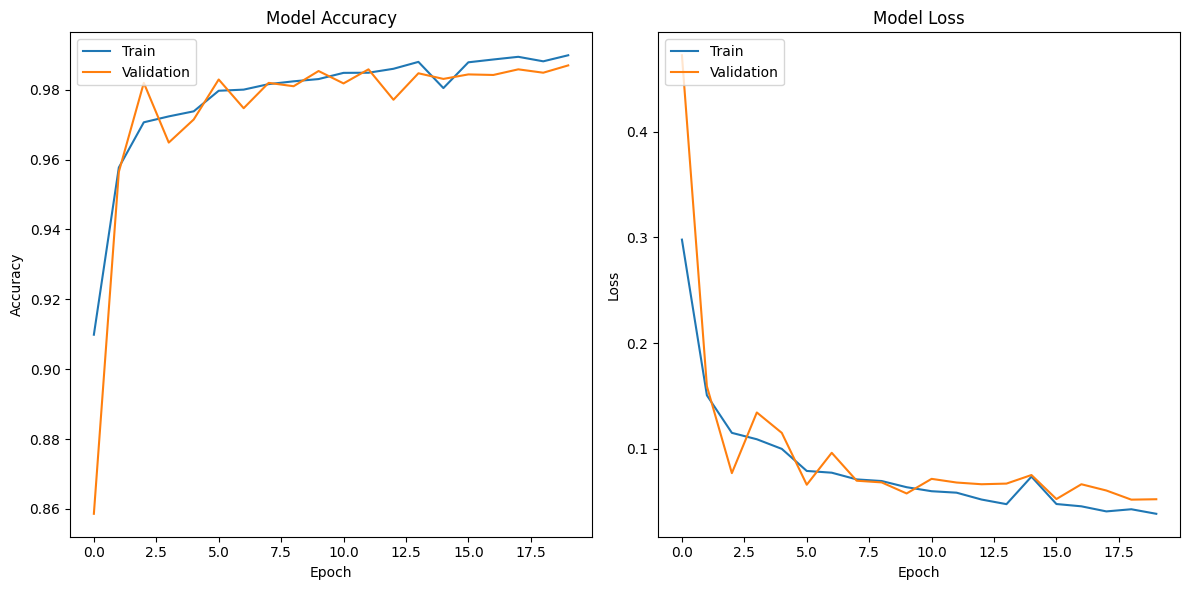

In [ ]:
history = cnn_attention.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

plot_training_history(history)

In [ ]:
y_pred = cnn_attention.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

# Menghitung dan mencetak akurasi
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Menghitung dan mencetak confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Menghitung dan mencetak classification report
class_report = classification_report(y_test, y_pred_classes)
print('Classification Report:')
print(class_report)

194/194 [==============================] - 11s 52ms/step
Accuracy: 0.9869
Confusion Matrix:
[[ 442    0   37    3    0]
 [   1 1559    0    0    2]
 [   7    5 1863   10    4]
 [   2    0    2 1261    0]
 [   2    3    3    0  996]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       482
           1       0.99      1.00      1.00      1562
           2       0.98      0.99      0.98      1889
           3       0.99      1.00      0.99      1265
           4       0.99      0.99      0.99      1004

    accuracy                           0.99      6202
   macro avg       0.99      0.98      0.98      6202
weighted avg       0.99      0.99      0.99      6202



In [ ]:
# Menghitung dan mencetak precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

# Menghitung dan mencetak sensitivity (recall)
sensitivity = recall_score(y_test, y_pred_classes, average='weighted')
print(f'Sensitivity (Recall): {sensitivity:.4f}')

# Menghitung dan mencetak F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9869
Sensitivity (Recall): 0.9869
F1 Score: 0.9868


In [20]:
# Fungsi untuk melakukan K-fold cross-validation
def k_fold_cross_validation(X, y, k=4, epochs=20, batch_size=32):
    # Inisialisasi KFold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    # Daftar untuk menyimpan model pada setiap fold
    models = []
    
    # Loop melalui setiap fold
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        print(f'Fold {fold}')
        
        # Split data menjadi data latih dan data validasi
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Inisialisasi model
        model = create_cnn_attention_gru_model(input_shape=input_shape, num_classes=9)
        
        # Latih model
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=2)
        
        plot_training_history(history)
        
        # Evaluasi model pada data validasi
        _, accuracy = model.evaluate(X_val, y_val, verbose=0)
        print(f'Validation Accuracy: {accuracy}')
        
        # Tambahkan model ke dalam daftar
        models.append(model)
        
        print()
    
    return models


Fold 1
Epoch 1/20
1993/1993 - 485s - loss: 0.3041 - accuracy: 0.9137 - val_loss: 0.1533 - val_accuracy: 0.9534 - 485s/epoch - 243ms/step
Epoch 2/20
1993/1993 - 468s - loss: 0.1350 - accuracy: 0.9629 - val_loss: 0.1254 - val_accuracy: 0.9678 - 468s/epoch - 235ms/step
Epoch 3/20
1993/1993 - 448s - loss: 0.1089 - accuracy: 0.9711 - val_loss: 0.0846 - val_accuracy: 0.9739 - 448s/epoch - 225ms/step
Epoch 4/20
1993/1993 - 463s - loss: 0.0958 - accuracy: 0.9747 - val_loss: 0.0802 - val_accuracy: 0.9716 - 463s/epoch - 232ms/step
Epoch 5/20
1993/1993 - 448s - loss: 0.0782 - accuracy: 0.9789 - val_loss: 0.1012 - val_accuracy: 0.9756 - 448s/epoch - 225ms/step
Epoch 6/20
1993/1993 - 452s - loss: 0.0746 - accuracy: 0.9799 - val_loss: 0.0716 - val_accuracy: 0.9824 - 452s/epoch - 227ms/step
Epoch 7/20
1993/1993 - 460s - loss: 0.0644 - accuracy: 0.9831 - val_loss: 0.0730 - val_accuracy: 0.9801 - 460s/epoch - 231ms/step
Epoch 8/20
1993/1993 - 494s - loss: 0.0615 - accuracy: 0.9836 - val_loss: 0.0461 - 

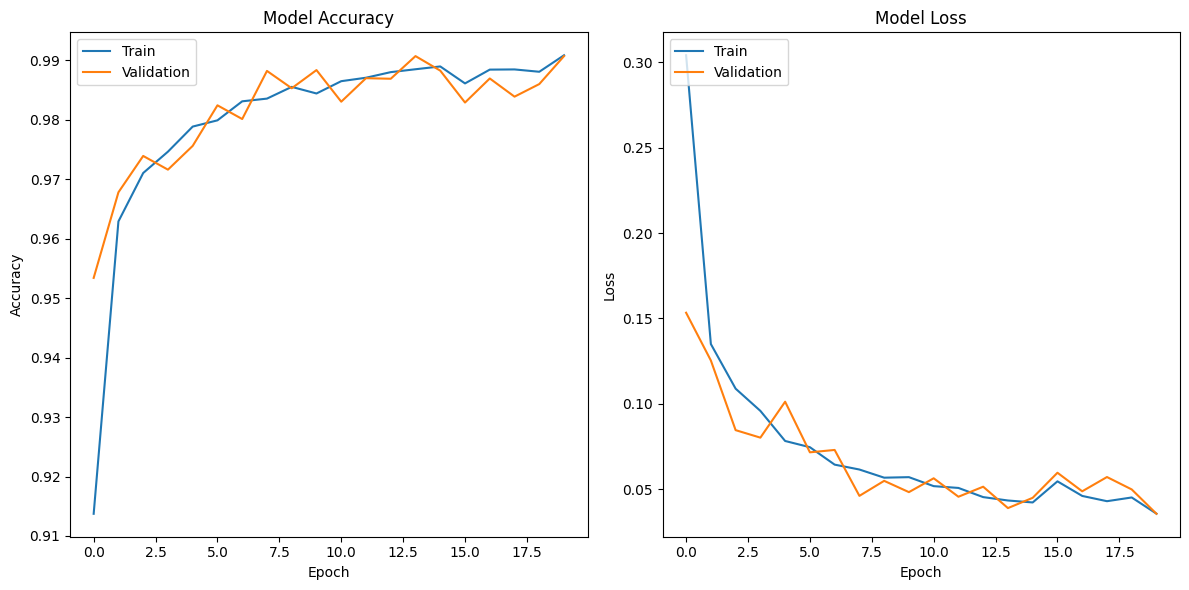

Validation Accuracy: 0.9907302856445312

Fold 2
Epoch 1/20
1993/1993 - 508s - loss: 0.3090 - accuracy: 0.9100 - val_loss: 0.2283 - val_accuracy: 0.9342 - 508s/epoch - 255ms/step
Epoch 2/20
1993/1993 - 457s - loss: 0.1438 - accuracy: 0.9614 - val_loss: 0.1247 - val_accuracy: 0.9689 - 457s/epoch - 229ms/step
Epoch 3/20
1993/1993 - 449s - loss: 0.1125 - accuracy: 0.9699 - val_loss: 0.0820 - val_accuracy: 0.9788 - 449s/epoch - 225ms/step
Epoch 4/20
1993/1993 - 490s - loss: 0.0937 - accuracy: 0.9756 - val_loss: 0.0664 - val_accuracy: 0.9819 - 490s/epoch - 246ms/step
Epoch 5/20
1993/1993 - 474s - loss: 0.0868 - accuracy: 0.9779 - val_loss: 0.0765 - val_accuracy: 0.9799 - 474s/epoch - 238ms/step
Epoch 6/20
1993/1993 - 446s - loss: 0.0709 - accuracy: 0.9811 - val_loss: 0.0624 - val_accuracy: 0.9824 - 446s/epoch - 224ms/step
Epoch 7/20
1993/1993 - 457s - loss: 0.0671 - accuracy: 0.9825 - val_loss: 0.0609 - val_accuracy: 0.9825 - 457s/epoch - 229ms/step
Epoch 8/20
1993/1993 - 444s - loss: 0.0640

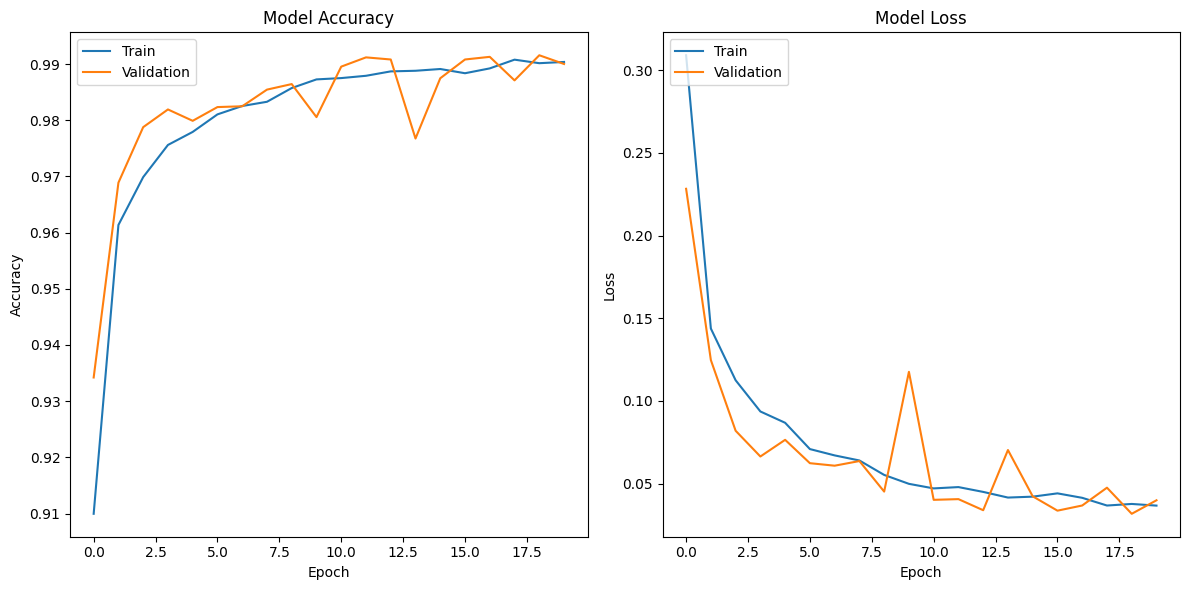

Validation Accuracy: 0.9900239706039429

Fold 3
Epoch 1/20
1993/1993 - 482s - loss: 0.3114 - accuracy: 0.9111 - val_loss: 0.1487 - val_accuracy: 0.9498 - 482s/epoch - 242ms/step
Epoch 2/20
1993/1993 - 458s - loss: 0.1388 - accuracy: 0.9620 - val_loss: 0.1170 - val_accuracy: 0.9707 - 458s/epoch - 230ms/step
Epoch 3/20
1993/1993 - 524s - loss: 0.1023 - accuracy: 0.9726 - val_loss: 0.0794 - val_accuracy: 0.9794 - 524s/epoch - 263ms/step
Epoch 4/20
1993/1993 - 544s - loss: 0.0893 - accuracy: 0.9763 - val_loss: 0.0807 - val_accuracy: 0.9785 - 544s/epoch - 273ms/step
Epoch 5/20
1993/1993 - 557s - loss: 0.0777 - accuracy: 0.9796 - val_loss: 0.0728 - val_accuracy: 0.9816 - 557s/epoch - 279ms/step
Epoch 6/20
1993/1993 - 453s - loss: 0.0703 - accuracy: 0.9812 - val_loss: 0.0782 - val_accuracy: 0.9816 - 453s/epoch - 228ms/step
Epoch 7/20
1993/1993 - 475s - loss: 0.0634 - accuracy: 0.9835 - val_loss: 0.0659 - val_accuracy: 0.9835 - 475s/epoch - 238ms/step
Epoch 8/20
1993/1993 - 462s - loss: 0.0608

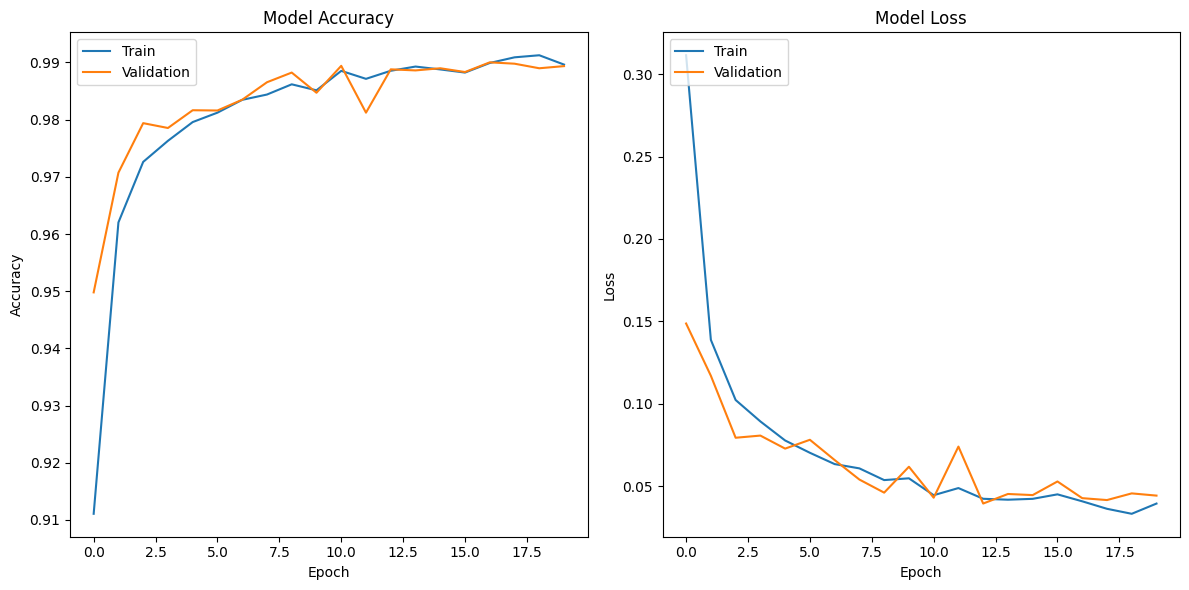

Validation Accuracy: 0.9893652200698853

Fold 4
Epoch 1/20
1993/1993 - 536s - loss: 0.3075 - accuracy: 0.9119 - val_loss: 0.1263 - val_accuracy: 0.9613 - 536s/epoch - 269ms/step
Epoch 2/20
1993/1993 - 516s - loss: 0.1467 - accuracy: 0.9607 - val_loss: 0.0941 - val_accuracy: 0.9711 - 516s/epoch - 259ms/step
Epoch 3/20
1993/1993 - 515s - loss: 0.1089 - accuracy: 0.9715 - val_loss: 0.0832 - val_accuracy: 0.9729 - 515s/epoch - 258ms/step
Epoch 4/20
1993/1993 - 505s - loss: 0.0963 - accuracy: 0.9743 - val_loss: 0.0673 - val_accuracy: 0.9817 - 505s/epoch - 254ms/step
Epoch 5/20
1993/1993 - 479s - loss: 0.0845 - accuracy: 0.9768 - val_loss: 0.0602 - val_accuracy: 0.9835 - 479s/epoch - 240ms/step
Epoch 6/20
1993/1993 - 441s - loss: 0.0715 - accuracy: 0.9802 - val_loss: 0.0656 - val_accuracy: 0.9821 - 441s/epoch - 221ms/step
Epoch 7/20
1993/1993 - 446s - loss: 0.0649 - accuracy: 0.9828 - val_loss: 0.0643 - val_accuracy: 0.9829 - 446s/epoch - 224ms/step
Epoch 8/20
1993/1993 - 426s - loss: 0.0648

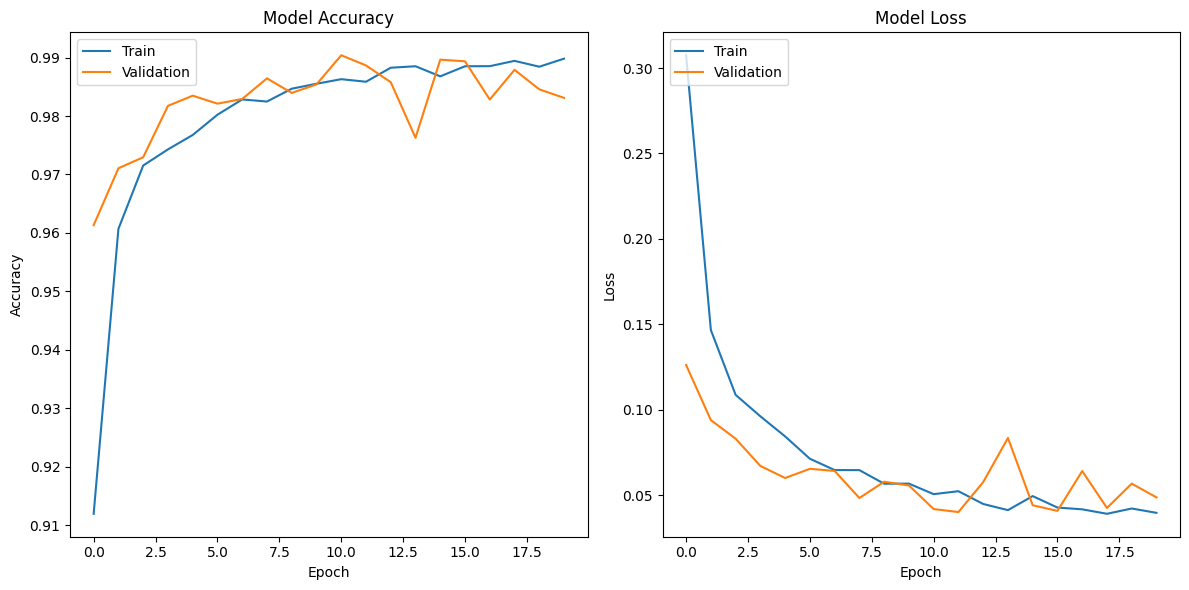

Validation Accuracy: 0.9831066727638245



In [27]:
cnn_attention_gru = k_fold_cross_validation(X_resampling, y_resampling)

In [33]:
y_pred = cnn_attention_gru[0].predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

# Menghitung dan mencetak akurasi
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Menghitung dan mencetak confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Menghitung dan mencetak classification report
class_report = classification_report(y_test, y_pred_classes)
print('Classification Report:')
print(class_report)

532/532 [==============================] - 22s 41ms/step
Accuracy: 0.9936
Confusion Matrix:
[[1936    0    0    2    0   12    0    0    1]
 [   0 1895    0    0    0    0    0    0    0]
 [   0    0 1880    0    0    0    1    3    0]
 [   0    0    0 1922    0    0    0    0    0]
 [   0    0    2    0 1818    4    0    2    0]
 [  11    0   24    1    1 1834    0    1    1]
 [   4    0    0    0    0    1 1932    0    0]
 [   3    3   25    1    1    4    0 1808    0]
 [   0    0    0    0    0    0    0    0 1868]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1951
           1       1.00      1.00      1.00      1895
           2       0.97      1.00      0.99      1884
           3       1.00      1.00      1.00      1922
           4       1.00      1.00      1.00      1826
           5       0.99      0.98      0.98      1873
           6       1.00      1.00      1.00      1937
           7       

In [34]:
# Menghitung dan mencetak precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

# Menghitung dan mencetak sensitivity (recall)
sensitivity = recall_score(y_test, y_pred_classes, average='weighted')
print(f'Sensitivity (Recall): {sensitivity:.4f}')

# Menghitung dan mencetak F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9937
Sensitivity (Recall): 0.9936
F1 Score: 0.9936


In [35]:
cnn_attention_gru[0].save('C:\\Users\\Administrator\\Documents\\TA\\cnn_attention_gru.h5')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


Save Model

In [ ]:
# cnn_lstm.save('C:\\Users\\Administrator\\Documents\\TA\\cnn_lstm.h5')
# cnn_gru.save('C:\\Users\\Administrator\\Documents\\TA\\cnn_gru.h5')
# cnn_rnn.save('C:\\Users\\Administrator\\Documents\\TA\\cnn_rnn.h5')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
